# Исследование объявлений о продаже квартир

#### Описание задачи
В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.  
Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

<a name='back'></a>
## Навигация по содержанию
- [Библиотеки](#libraries)  
- [1. Знакомство с данными ](#dataintro)  
- [2. Предобработка данных](#datacleaning)      
- [3. Дополнительные расчеты](#addinfo)
- [4. Исследовательский анализ данных](#analysis)
- [7. Общий вывод](#conclusion)

#### Библиотеки

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')  

## 1. Знакомство с данными <a name="dataintro"></a>
#### [Вернуться к оглавлению](#back) 

In [3]:
data = pd.read_csv('datasets/flats_project2', index_col=0) # читаем файл
pd.set_option('display.max_columns', 200) # добавдяем число отображаемых колонок 
# просматриваем форму таблицы и знакомимся с содержанием по первым строкам:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
# Оставим только полезные для исследования столбцы
data = data[['last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'kitchen_area', 'locality_name', 'cityCenters_nearest', 'days_exposition']]

### Вывод

#### Столбцы
'total_images', 'airports_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'is_apartment', 'balcony', 'studio', 'open_plan', 'days_exposition', 'living_area', 'kitchen_area'  
не несут полезной для исследования информации, их можно не трогать.

#### Пропуски
Остальные столбцы, где обнаружены пропущенные данные, нужно обработать:   
- `ceiling_height` - заменить пропуски средним или стандартом  
- `cityCenters_nearest` - если возможно, заменить на медиану по категории locality_name  
- `floors_total` - удалить строки с пропусками
- `locality_name`  - удалить строки с пропусками

#### Типы данных
Обнаружены ошибочные типы данных некоторых столбцов, их нужно будет заменить после обработки пропусков:  
- `first_day_exposition` - object to datetime  
- `floors_total` - float64 to int  

## 2. Предобработка данных 
<a name="datacleaning"></a>
#### [Вернуться к оглавлению](#back) 

#### Работа с дубликатами

In [5]:
# проверка числа полностью дублирующихся строк
data.duplicated().sum()

0

In [6]:
# проверка числа дублирующихся строк после приведения строкового столбца к строчному виду 
data_test = data.copy()
data_test['locality_name'] = data['locality_name'].str.lower()
data_test.duplicated().sum()

0

#### Обработка пропусков

In [7]:
# Напишем функции для определения границ верхнего и нижнего усов. Это понадобится для выявления выбросов.
def top_whisker_cap(column):
    q1 = column.quantile(0.25) 
    q3 = column.quantile(0.75)
    top_wisk_cap = q3 + 1.5 * (q3 - q1)
    return print('Граница верхнего уса:', top_wisk_cap)

def bottom_whisker_cap(column):
    q1 = column.quantile(0.25) 
    q3 = column.quantile(0.75)
    bottom_wisk_cap = q1 - 1.5 * (q3 - q1)
    return print('Граница нижнего уса:', bottom_wisk_cap)

In [8]:
# Так как строки с пропущенными значениями locality_name составляют 0.21% данных, удаляем их 
data = data[data['locality_name'].isna() == False]
data['locality_name'].isna().sum() # проверка результата 

0

In [9]:
# Так как строки с пропущенными значениями total_floors составляют 0,36% данных, удаляем их 
data = data[data['floors_total'].isna() == False]
data['floors_total'].isna().sum() # проверка результата

0

Граница нижнего уса: 2.0749999999999997
None
Граница верхнего уса: 3.235
None


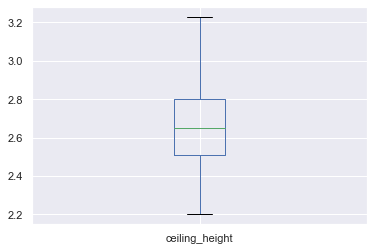

In [10]:
# Обработка прпусков в столбце ceiling_height. Заменим пропуски медианой.

# Чтобы эта замена не повлияла на определение выбросов, выявим их сейчас и также заменим медианой.
# Строим ящик с усами для выявления выбросов в столбце ceiling_height:
data.boxplot(column='ceiling_height', showfliers=False)
print(bottom_whisker_cap(data['ceiling_height'])) # смотрим численное значение гранцы нижнего уса
print(top_whisker_cap(data['ceiling_height'])) # смотрим численное значение гранцы верхнего уса

In [11]:
# Делаем вывод: все значения, находящиеся ниже 2.1 и выше 3.2 являются выбросами, заменим их на медиану
data.loc[data['ceiling_height'] < 2.10, 'ceiling_height'] = data['ceiling_height'].median()
data.loc[data['ceiling_height'] > 3.20, 'ceiling_height'] = data['ceiling_height'].median()

In [12]:
# Теперь заменим пропуски в ceiling_height медианой
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

In [13]:
# Медиана расстояния от центра по населенному пункту
city_center_by_loc = data.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc='median')
city_center_by_loc

,cityCenters_nearest
locality_name,
Зеленогорск,53381.0
Колпино,32018.0
Красное Село,29148.5
Кронштадт,49575.0
Ломоносов,51677.0
Павловск,32683.0
Петергоф,33771.0
Пушкин,27930.5
Санкт-Петербург,12242.0


Видим, что значения `cityCenters_nearest` указаны далеко не во всех локациях.  
Произвести замену в большинстве строк невозможно.

#### Замена типов данных

In [14]:
# меняем тип first_day_exposition на datetime:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M:%S')
# меняем тип floors_total на int:
data['floors_total'] = data['floors_total'].astype(int)
data['last_price'] = data['last_price'].astype(int)
data.info() #смотрим типы данных интересующих нас столбцов

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 12 columns):
last_price              23565 non-null int64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             21700 non-null float64
floor                   23565 non-null int64
kitchen_area            21343 non-null float64
locality_name           23565 non-null object
cityCenters_nearest     18064 non-null float64
days_exposition         20394 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 2.3+ MB


### Выводы
Дубликатов в таблице не обнаружено.  

Удалены строки с пропусками в столбцах `floors_total` и `locality_name`, так как их доля составляла менее 1% данных и это не сильно повлияет на результаты исследования.  
Пропуски в столбце `ceiling_height` заменены медианой из-за наличия артефактов в данных.  
Заполнить пропуски в `cityCenters_nearest` по медиане в населенном пункте не удалось, так как значения `cityCenters_nearest` указаны только в 28 локациях из 364. Удаление такого большого числа строк повлияло бы на объективность данных, поэтому оставим строки с пропусками в этом столбце. 

Типы данных приведены к корректным.

## 3. Дополнительные расчеты
<a name="addinfo"></a>
#### [Вернуться к оглавлению](#back) 

Добавим:  
•	цену квадратного метра;  
•	день недели, месяц и год публикации объявления;  
•	этаж квартиры (варианты — первый, последний, другой);  
•	соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [15]:
# Добавляем в таблицу столбец с ценой квадратного метра
data['cost_per_sq_m'] = (data['last_price'] / data['total_area']).round(2)

In [16]:
# Добавляем день недели, месяц и год публикации объявления
data['weekday_of_listing'] = data['first_day_exposition'].dt.weekday
data['month_of_listing'] = data['first_day_exposition'].dt.month
data['year_of_listing'] = data['first_day_exposition'].dt.year

In [17]:
# Добавляем этаж квартиры: варианты — первый, последний, другой.

data['floor_class'] = ' ' # создаем новый столбец для категории этажей
# пишем функцию, проверяющую этаж на первы/последний по условию, в обратном случае возвращающую "другой"
def floor_class(row):
    floor = row['floor']
    floors_total = row['floors_total']
    floor_class = row['floor_class']
    try:
        if floor == 1:
            floor_class = 'первый'
            return floor_class
        elif floor == floors_total:
            floor_class = 'последний'
            return floor_class
        else: 
            floor_class = 'другой'
            return floor_class
    except:
        floor_class = 'нет информации'
        
# написанную применяем функцию для строки, результат складываем в столбец 'floor_class'
data['floor_class'] = data.apply(floor_class, axis=1) 

data['floor_class'].value_counts()

другой       17326
последний     3330
первый        2909
Name: floor_class, dtype: int64

In [18]:
# Заполним пропуски в kitchen_area и living_area 
# Для этого найдем коэффициент отношения площади кухни к общей и жилой площади к общей 
# и умножим его на общую плошадь в строках с пропусками

# Добавляем соотношение жилой и общей площади, а также отношение площади кухни к общей
data['living_to_total_ratio'] = data['living_area'] / data['total_area'] # считаем соотношение жилой и общей площади
data['kitchen_to_total_ratio'] = data['kitchen_area'] / data['total_area'] # считаем отношение площади кухни к общей

# Вычислим среднее отношение площади кухни к общей и жилой площади к общей
living_to_total_coef = data['living_to_total_ratio'].mean()
kitchen_to_total_coef = data['kitchen_to_total_ratio'].mean()

# Произведем соответствующую замену пропусков в kitchen_area и living_area 
data.loc[data['living_area'].isna()==True, 'living_area'] = data['total_area'] * living_to_total_coef
data.loc[data['kitchen_area'].isna()==True, 'kitchen_area'] = data['total_area'] * kitchen_to_total_coef

# Округлим полученные значения
data['kitchen_area'] = data['kitchen_area'].round(2)
data['living_area'] = data['living_area'].round(2)

In [19]:
# Также добавим столбец с расстоянием до центра в километрах
data['km_to_center'] = (data['cityCenters_nearest'] / 1000).round()
data.head() # смотрим на обновленную таблицу

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,locality_name,cityCenters_nearest,days_exposition,cost_per_sq_m,weekday_of_listing,month_of_listing,year_of_listing,floor_class,living_to_total_ratio,kitchen_to_total_ratio,km_to_center
0,13000000,108.0,2019-03-07,3,2.70,16,51.00,8,25.00,Санкт-Петербург,16028.0,NaN,120370.37,3,3,2019,другой,0.472222,0.231481,16.0
1,3350000,40.4,2018-12-04,1,2.65,11,18.60,1,11.00,посёлок Шушары,18603.0,81.0,82920.79,1,12,2018,первый,0.460396,0.272277,19.0
2,5196000,56.0,2015-08-20,2,2.65,5,34.30,4,8.30,Санкт-Петербург,13933.0,558.0,92785.71,3,8,2015,другой,0.612500,0.148214,14.0
3,64900000,159.0,2015-07-24,3,2.65,14,89.83,9,29.79,Санкт-Петербург,6800.0,424.0,408176.10,4,7,2015,другой,NaN,NaN,7.0
4,10000000,100.0,2018-06-19,2,3.03,14,32.00,13,41.00,Санкт-Петербург,8098.0,121.0,100000.00,1,6,2018,другой,0.320000,0.410000,8.0


## 4. Исследовательский анализ данных
<a name="analysis"></a>
#### [Вернуться к оглавлению](#back) 

Проведем исследовательский анализ данных и выполним следующее:  
- Изучим следующие параметры: площадь, цена, число комнат, высота потолков;
- Изучим время продажи квартиры. Определим, когда можно считать, что продажи прошли очень быстро, а когда необычно долго;
- Уберем редкие и выбивающиеся значени;

- Определим, какие факторы больше всего влияют на стоимость квартиры. Изучим, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучим зависимость от даты размещения: дня недели, месяца и года.

- Посчитаем среднюю цену квадратного метра в 10 населённых пунктов с наибольшим числом объявлений, определим населённые пункты с самой высокой и низкой стоимостью жилья;

- Выясним, какая область входит в центр в Санкт-Петербурга;
- Выделим сегмент квартир в центре и проанализируем эту территорию. Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления);
- Сравним влияние факторов на цены квартир в центре и по всему городу.

##### Площадь, цена квартир, число комнат, высота потолков

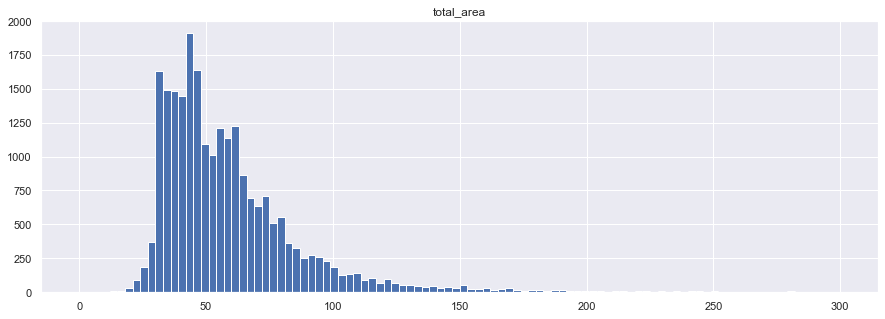

In [20]:
# Посмотрим на данные поближе - построим гистограмму распределения площади
data.hist('total_area', bins=100, figsize=(15,5), range=(0,300));

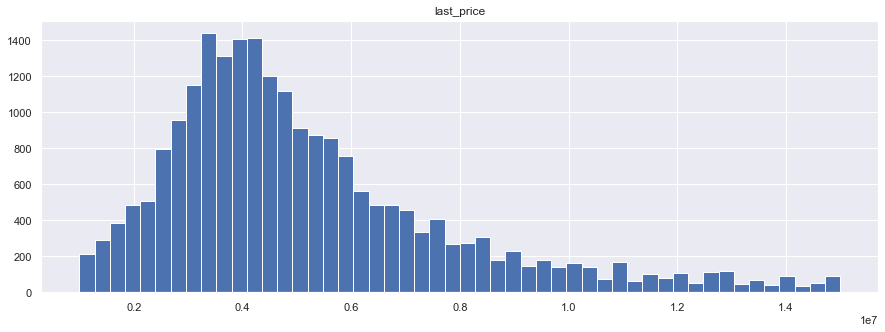

In [21]:
# построим гистограмму цен
data.hist('last_price', bins=50, range=(1000000, 15000000), figsize=(15,5));

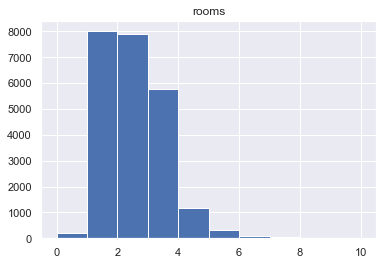

In [22]:
# построим гистограмму по числу комнат
data.hist('rooms', bins=10, range=(0,10));

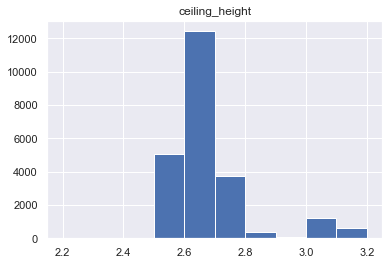

In [23]:
# построим гистограмму высоты потолков. 
data.hist('ceiling_height');

По графикам распределения велечин выше видим, что в Ленинградской области в среднем:  
- Больше всего квартир с площадью около 45-49 кв.м, немного квартир меньше 30 кв.м и более 70 кв.м;
- Больше всего квартир в ценовом диапазоне 3-5 млн руб, квартиры стоимостью меньше 2 млн и больше 7 млн встречаются нечасто;
- Самые часто встречающиеся - однокомнатные и двухкомнатные квартиры, чуть меньше-трехкомнатные. Больше 4 комнат - редкость;
- В основном высота потолков между 2.5 и 2.7 м.

###### Время продажи квартиры

In [24]:
data

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,locality_name,cityCenters_nearest,days_exposition,cost_per_sq_m,weekday_of_listing,month_of_listing,year_of_listing,floor_class,living_to_total_ratio,kitchen_to_total_ratio,km_to_center
0,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,25.00,Санкт-Петербург,16028.0,NaN,120370.37,3,3,2019,другой,0.472222,0.231481,16.0
1,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,11.00,посёлок Шушары,18603.0,81.0,82920.79,1,12,2018,первый,0.460396,0.272277,19.0
2,5196000,56.00,2015-08-20,2,2.65,5,34.30,4,8.30,Санкт-Петербург,13933.0,558.0,92785.71,3,8,2015,другой,0.612500,0.148214,14.0
3,64900000,159.00,2015-07-24,3,2.65,14,89.83,9,29.79,Санкт-Петербург,6800.0,424.0,408176.10,4,7,2015,другой,NaN,NaN,7.0
4,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,41.00,Санкт-Петербург,8098.0,121.0,100000.00,1,6,2018,другой,0.320000,0.410000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9700000,133.81,2017-03-21,3,2.65,5,73.30,3,13.83,Санкт-Петербург,4232.0,NaN,72490.85,1,3,2017,другой,0.547792,0.103356,4.0
23695,3100000,59.00,2018-01-15,3,2.65,5,38.00,4,8.50,Тосно,NaN,45.0,52542.37,0,1,2018,другой,0.644068,0.144068,NaN
23696,2500000,56.70,2018-02-11,2,2.65,3,29.70,1,10.62,село Рождествено,NaN,NaN,44091.71,6,2,2018,первый,0.523810,NaN,NaN
23697,11475000,76.75,2017-03-28,2,3.00,17,43.36,12,23.30,Санкт-Петербург,10364.0,602.0,149511.40,1,3,2017,другой,NaN,0.303583,10.0


count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

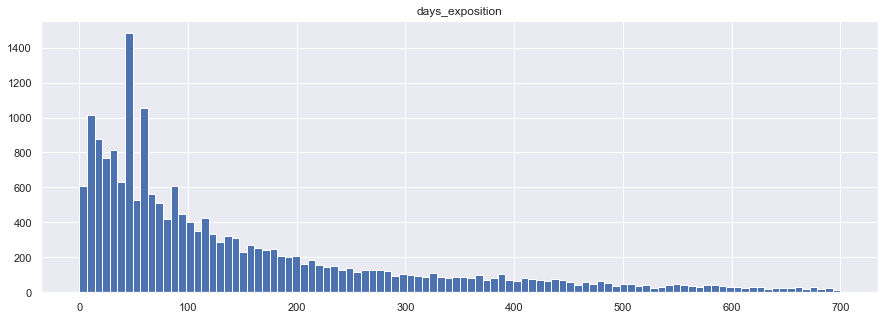

In [25]:
# Изучим влияние время продажи квартиры на ее цену 
# построим гистограмму времени продажи квартиры по срезу, исключающему строки с пропуками в столбце days_exposition
data.query('days_exposition != "NaN"').hist('days_exposition', figsize=(15, 5), bins=100, range=(0,700))
data.query('days_exposition != "NaN"')['days_exposition'].describe() # посмотрим среднее и медиану

Граница верхнего уса: 510.0


count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

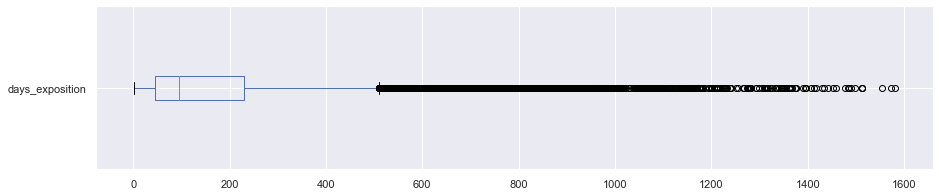

In [26]:
# постром гистограмму веремни продажи квартиры, чтобы посмотреть, какие значения выпадают за границы "привычных"
data.query('days_exposition != "NaN"').boxplot(['days_exposition'], vert=False, figsize=(15,3)) 
top_whisker_cap(data.query('days_exposition != "NaN"')['days_exposition']) # посчитаем границы верхнего уса
data.query('days_exposition != "NaN"')['days_exposition'].describe() # посмотрим медиану и среднее

В Ленинградской области средний срок продажи квартиры составляет 180 дней, однако чаще всего квартиры продаются за 95 дней. Можно считать, что продажи прошли быстро, если срок составляет менее 45 дней (случаеися в 25% случаев), в редких случаях это занимет более 231 дня. Крайне редко – более 510 дней (5% случаев).


##### Работа с выбросами

Граница верхнего уса: 114.25
Граница нижнего уса:  12.0


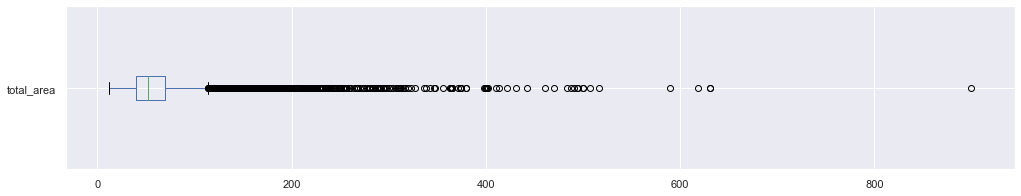

In [27]:
# Уберем редкие и выбивающиеся значения. Для этого строим ящики с усами и определяем их границы.
# Выбросы по высоте потолков мы уже обработали на шаге 2.

# ящик с усами и его границы для площади квартир:
data.boxplot(column=['total_area'], vert=False, figsize=(17,3))
top_whisker_cap(data['total_area'])
print('Граница нижнего уса: ', data['total_area'].min()) # граница нижнего уса здесь является минимальным значением 

# уберем значения за границей верхнего уса, оставшиийся срез назовем clean_data
clean_data = data.query('total_area<=114.75')

Граница верхнего уса: 11875000.0


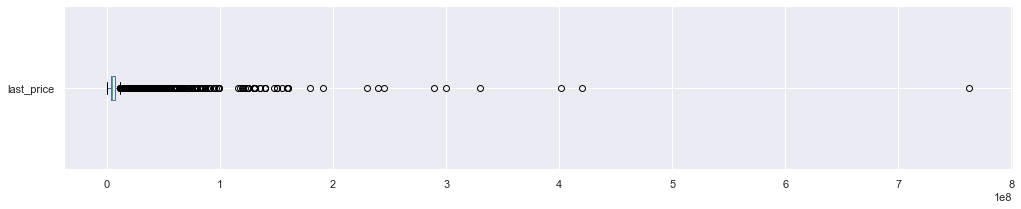

In [28]:
# ящик с усами и его границы для цен на квартиры:
data.boxplot(column=['last_price'], vert=False, figsize=(17,3)) 
#plt.xlim(0, 25000000)
#plt.show()
top_whisker_cap(data['last_price'])

# уберем значения за границей верхнего уса, оставшиеся данные добавим в clean_data
clean_data = data.query('total_area<=114.5 and last_price<=11897500.0')

Граница верхнего уса: 6.0


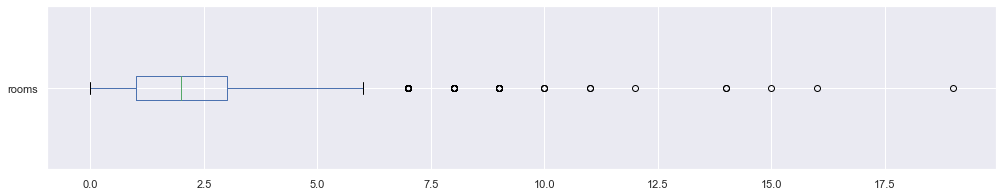

In [29]:
# ящик с усами и его границы для числа комнат в квартирах:
data.boxplot(column=['rooms'], vert=False, figsize=(17,3)) 
top_whisker_cap(data['rooms'])

# уберем значения за границей верхнего уса, оставшиеся данные добавим в clean_data
clean_data = data.query('total_area<=114.5 and last_price<=11897500.0 and rooms<=6')

In [30]:
# взглянем на таблицу с очищенными от выбросов значениями
clean_data.head()

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,locality_name,cityCenters_nearest,days_exposition,cost_per_sq_m,weekday_of_listing,month_of_listing,year_of_listing,floor_class,living_to_total_ratio,kitchen_to_total_ratio,km_to_center
1,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,11.0,посёлок Шушары,18603.0,81.0,82920.79,1,12,2018,первый,0.460396,0.272277,19.0
2,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,8.3,Санкт-Петербург,13933.0,558.0,92785.71,3,8,2015,другой,0.612500,0.148214,14.0
4,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,41.0,Санкт-Петербург,8098.0,121.0,100000.00,1,6,2018,другой,0.320000,0.410000,8.0
5,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,9.1,городской посёлок Янино-1,NaN,55.0,95065.79,0,9,2018,другой,0.473684,0.299342,NaN
6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,14.4,посёлок Парголово,19143.0,155.0,99195.71,3,11,2017,другой,0.284182,0.386059,19.0


### Выводы

Для оценивания обобщенной статистики без редких и возможных ошибочных значений, удалены выходящие за границы усов значения в столбцах, которые мы будем рассматривать как влияющие на цену факторы.  
По очищенным от выбросов данным,
- площадь квартир варьируется от 12 до 114.25 квадратных метров,
- стоимость квартир доходит до 11,875,000 рублей,
- квартиры бывают студии или имеют до 6 комнат,
- высота потолков составляет от 2.1 до 3.2 м. 

##### Факторы, влияющие на стоимость квартиры  

In [31]:
# Смотрим на коэффициенты корреляций last price и остальных параметров
data.corr()['last_price'].reset_index().sort_values(by='last_price', ascending=False)\
.style.background_gradient(cmap = 'coolwarm')

,index,last_price
0,last_price,1
10,cost_per_sq_m,0.736799
1,total_area,0.653621
5,living_area,0.585549
7,kitchen_area,0.517032
2,rooms,0.363191
3,ceiling_height,0.171982
9,days_exposition,0.0808579
6,floor,0.0268418
12,month_of_listing,0.00272596


По таблице корреляций видим, что конечная стоимость квартитры сильнее всего зависит от цены за квадратный метр, размера квартиры и связанных с этим параметров. Также есть (хоть и слабая) обратная корреляция с расстоянием от центра - чем дальше от него, тем дешевле квартира.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


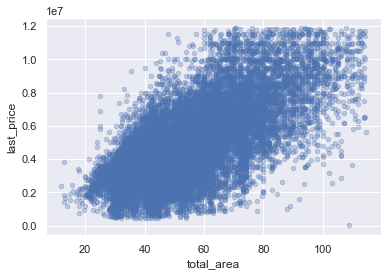

In [32]:
# Строим диаграмму рассеивания по цене и площиди
clean_data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


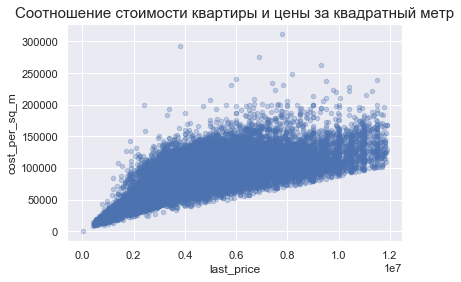

In [33]:
# Строим диаграмму рассеивания по цене и цене за кв метр
clean_data.plot(x='last_price', y='cost_per_sq_m', kind='scatter', alpha=0.3)
plt.title('Соотношение стоимости квартиры и цены за квадратный метр', fontsize=15)
plt.show();

#### Вывод
В целом, в более дорогих квартирах цена за квадратный метр выше, но в этой тенденции есть исключения, а так же вероятно влияние других факторов.

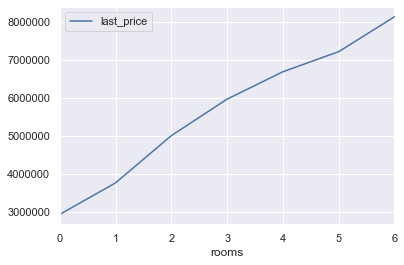

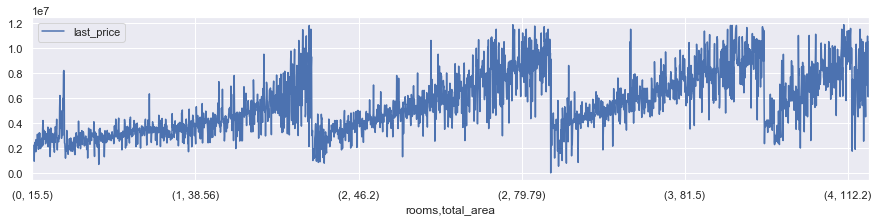

In [34]:
# рассмотрим графики зависимостей цены от количества комнат и цены от количетсва комнат и площади
clean_data.pivot_table(index=['rooms'], values='last_price').plot()
clean_data.pivot_table(index=['rooms', 'total_area'], values='last_price').plot(figsize=(15,3));

#### Вывод
На цену влияет количество комнат, но также это связанно и с соответствующим увеличении общей площади (в квартирах побольше обычно больше комнат). Так, мы видим, что квартиры с меньшим количеством комнат, но большей площадью дороже, чем квартиры поменьше с большим количеством комнат.  
Таким образом, влияние общей площади квартиры на цену сильнее, чем количество комнат.

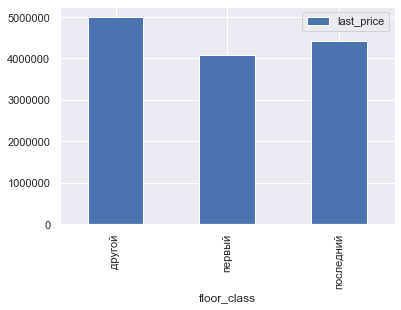

In [35]:
# рассмотрим зависимость цены от этажа квартиры по бар чату по сводной таблице
clean_data.pivot_table(index='floor_class', values='last_price').plot(kind='bar');

#### Вывод
Обычно квартиры на первом этаже немного дешевле.

Коэффициент корреляции цены и отдаленности от центра равен -35%


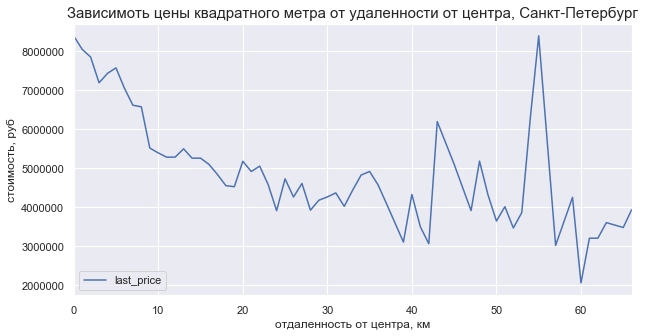

In [36]:
# Отбросим строки с нулевыми значениями в столбце cityCenters_nearest, 
# составим сводную таблицу из этого среза по отдаленности от центра и цене
print('Коэффициент корреляции цены и отдаленности от центра равен {:,.0%}'.format(clean_data['km_to_center'].corr(clean_data['last_price'])))

clean_data.query('cityCenters_nearest != "NaN"').pivot_table(index='km_to_center',
                                                            values='last_price').plot(grid=True, figsize=(10,5))
plt.xlabel('отдаленность от центра, км')
plt.ylabel('стоимость, руб')
plt.title('Зависимоть цены квадратного метра от удаленности от центра, Санкт-Петербург', fontsize=15)
plt.show()

#### Вывод
С расстоянием от центра стоимость уменьшается, но коэффициент обратной корреляции не высокий (-35%), значит, другие факторы тоже важны.
На графике мы видим, что до 40 км от центра цены на квартиры снижаются, однако около 45 и 55 км от центра резко взлетают. Предположительно, там находятся крупные населенные пункты.

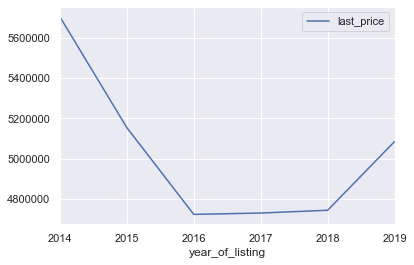

In [37]:
# Посмотрим, как менялась средняя цена на квартиры в период с 2014 по 2019 гг.
# построим сводную таблицу и график зависимости цен от года
clean_data.pivot_table(index='year_of_listing', values='last_price').plot(); 

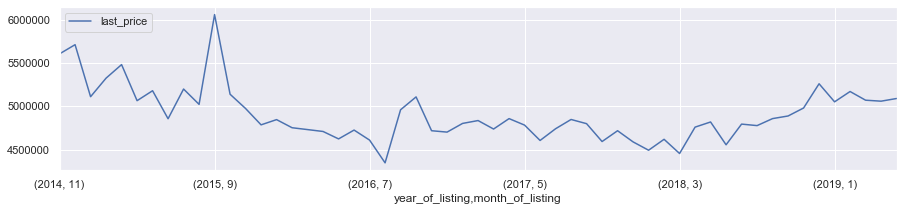

In [38]:
# Рассмотрим динамику цен по времени более детально
# построим сводную таблицу и график зависимости цены от месяца и года выставления квартиры на продажу

clean_data.pivot_table(index=['year_of_listing', 'month_of_listing'], 
                       values='last_price').plot(figsize=(15,3), grid=True)
plt.legend(loc='upper left')
plt.show()

#### Вывод
В период с 2014 года цены были максимальны в 2014, затем резко снижались в течение двух лет, достигнув минимума в 2016 году. С 2018 года отмечается значительное повышение цен.  
При этом в сентябре 2015 был резкий скачок цен (средняя цена квартиры в Ленинградской области тогда достигла пика за 5 лет - более 6 млн руб), но за этим последовало быстрое снижение отметки чуть более 4,75 млн руб в течение нескольких месяцев.  
К началу 2019 года цены вышли на уровень середины 2015 года.

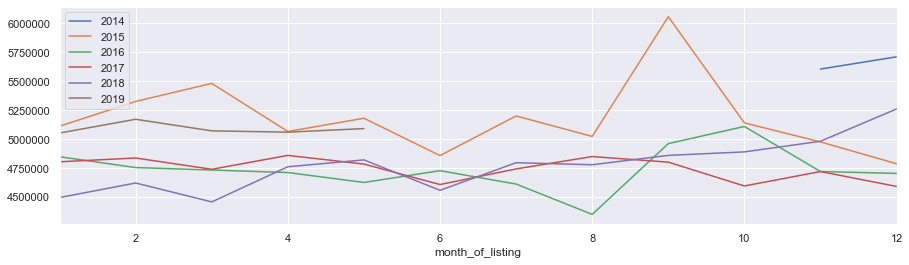

In [39]:
# построим сводную таблицу и график зависимости цены от месяца выставления квартиры на продажу, разделеный по годам
clean_data.pivot_table(index='month_of_listing', columns='year_of_listing', values='last_price').plot(figsize=(15,4),
                                                                                                      grid=True)
plt.legend(loc='upper left')
plt.show()

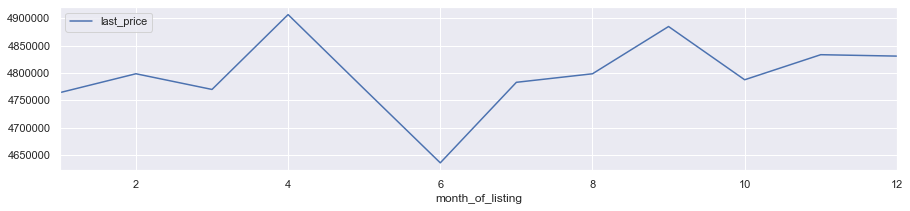

In [40]:
# построим сводную обобщенные для всех лет таблицу и график зависимости цены от месяца выставления квартиры на продажу
clean_data.pivot_table(index=['month_of_listing'], values='last_price').plot(figsize=(15,3), grid=True)
plt.legend(loc='upper left')
plt.show()

#### Вывод
По графику зависимости цен от месяца можем видеть тенденцию к сезонному снижению цен в июне (исключение составлял 2016 год) и росту к сентябрю.

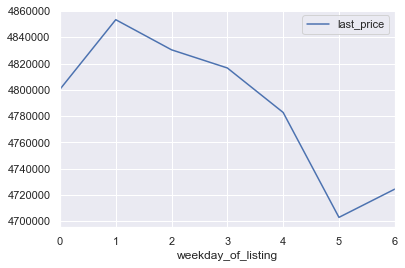

In [41]:
# построим сводную таблицу и график зависимости цены от дня недели выставления квартиры на продажу
clean_data.pivot_table(index=['weekday_of_listing'], values='last_price').plot(grid=True);

#### Вывод
В целом, квартиры дороже выставляли на продажу во вторник, дешевле - в субботу.

### Выводы 

**Факторы, влияющие на цену квартир:**  

***- Общая площадь (влияет прямо, но далеко не всегда)***  
Нередко за одну стоимость можно найти квартиры разной площади.Так, за примерно 2млн руб можно купить квартиру площадью от 20 до 40 кв м. Это означает, что сильно влияние других факторов.

***- Цена квадратного метра (влияет прямо, но не всегда)***  
В целом, в более дорогих квартирах цена за квадратный метр выше, но в этой тенденции есть исключения, а так же вероятно влияние других факторов.  

***- Количество комнат (влияет, но связанно с увеличением общей площади)***  
На цену влияет количество комнат, но также это связанно и с соответствующим увеличении общей площади (в квартирах побольше обычно больше комнат). Так, мы видим, что квартиры с меньшим количеством комнат, но большей площадью, дороже, чем квартиры поменьше с большим количеством комнат. Таким образом, влияние общей площади квартиры на цену сильнее, чем количество комнат.

***- Этаж (квартиры на первом этаже дешевле)***  
Обычно квартиры на первом этаже немного дешевле, а вот разница в стоимости квартир на последнем этаже и прочих выше первого незначительна. 

***- Удаленность от центра (чем дальше от центра, тем дешевле, но есть исключения)***  
С расстоянием от центра стоимость уменьшается, но коэффициент обратной корреляции не высокий (35%), значит, другие факторы тоже важны. До 40 км от центра цены на квартиры снижаются, однако около 45 и 55 км от центра резко взлетают. Предположительно, там находятся крупные населенные пункты.  

***- Год размещения на продажу (определенно влияет, но определен иными факторами)***  
Зависимость цен от даты размещения вероятнее всего зависит от экономических факторов и событий, таких как кризисы и колебания курсов валют.   
В период с 2014 года цены были максимальны в 2014, затем резко снижались в течение двух лет, достигнув минимума в 2016 году. С 2018 года отмечается значительное повышение цен.  
При этом в сентябре 2015 был резкий скачок цен (средняя цена квартиры в Ленинградской области тогда достигла пика за 5 лет - более 6 млн руб), но за этим последовало быстрое снижение отметки чуть более 4,75 млн руб в течение нескольких месяцев.  
К началу 2019 года цены вышли на уровень середины 2015 года.  

***- Сезонность (обычно в июне цены ниже, но не всегда)***  
По графику зависимости цен от месяца, можем видеть тенденцию к сезонному снижению цен в июне (исключение составлял 2016 год) и росту к сентябрю.  

***- День недели (статистическая тенденция есть, но неизвестно, чем она обусловлена)***  
В целом, квартиры дороже выставляли на продажу во вторник, дешевле - в субботу. Возможно, такая тенденция является случайной.

##### Населенные пункты с самой высокой и низкой стоимостью жилья

In [42]:
# выбираем 10 населённых пунктов с наибольшим числом объявлений
top10_localities = clean_data['locality_name'].value_counts().head(10).index
top10_localities_data = clean_data.query('locality_name in @top10_localities') # срез данных clean_data с этими городами
cost_psqm_top10 = top10_localities_data.pivot_table(index='locality_name', values='cost_per_sq_m') # средняя цена квадратного метра в этих населённых пунктах
cost_psqm_top10.sort_values(by=['cost_per_sq_m'], ascending=False)

,cost_per_sq_m
locality_name,
Санкт-Петербург,105696.889780
Пушкин,100462.063512
деревня Кудрово,92409.726309
посёлок Парголово,90332.262638
посёлок Мурино,85673.259885
посёлок Шушары,78578.068303
Колпино,75221.876299
Гатчина,68664.035611
Всеволожск,67222.431447


#### Вывод

Населённые пункты с самой высокой стоимостью жилья: Санкт-Петербург (110,728.27 руб за кв м), Пушкин (101,960.37 руб за кв м), 
деревня Кудрово (92,409.73 руб за кв м).  
Населённые пункты с самой низкой стоимостью жилья: Гатчина (68,919.47 руб за кв м), Всеволожск (68,673.57 руб за кв м), 
Выборг (58,225.62 руб за кв м).  

##### Граница центральной зоны Санкт-Петербурга

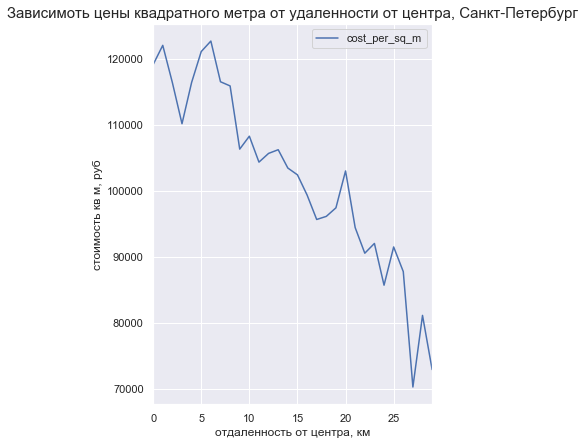

In [43]:
# Разберем зависимоть цены квадратного метра от удаленности от центра в Санкт-Петербурге
spb = clean_data.query('locality_name=="Санкт-Петербург" and cityCenters_nearest != "NaN"')
spb.pivot_table(index='km_to_center', values='cost_per_sq_m').plot(grid=True, figsize=(5,7))
plt.xlabel('отдаленность от центра, км')
plt.ylabel('стоимость кв м, руб')
plt.title('Зависимоть цены квадратного метра от удаленности от центра, Санкт-Петербург', fontsize=15)
plt.show()

#### Вывод
В центральную зону Санкт-Петербурга входит область в радиусе 8 км от центра.

##### Сегмент квартир в центре Санкт-Петербурга

In [44]:
spb_downtown = spb.query('km_to_center<=8') # сегмент квартир в центре

In [45]:
# Смотрим на коэффициенты корреляций last price и остальных параметров для этого сегмента
spb_downtown.corr()['last_price'].reset_index().sort_values(by='last_price', ascending=False)\
.style.background_gradient(cmap = 'coolwarm')

,index,last_price
0,last_price,1
1,total_area,0.71373
5,living_area,0.571567
2,rooms,0.460467
7,kitchen_area,0.45136
10,cost_per_sq_m,0.26245
9,days_exposition,0.154553
3,ceiling_height,0.145793
6,floor,0.130385
4,floors_total,0.103895


Стоимоть квартир в центральной зоне Санкт-Петербурга сильнее всего зависит от общей площади, и почти не коррелируется с ценой за квадратный метр (в отличие от всей области).

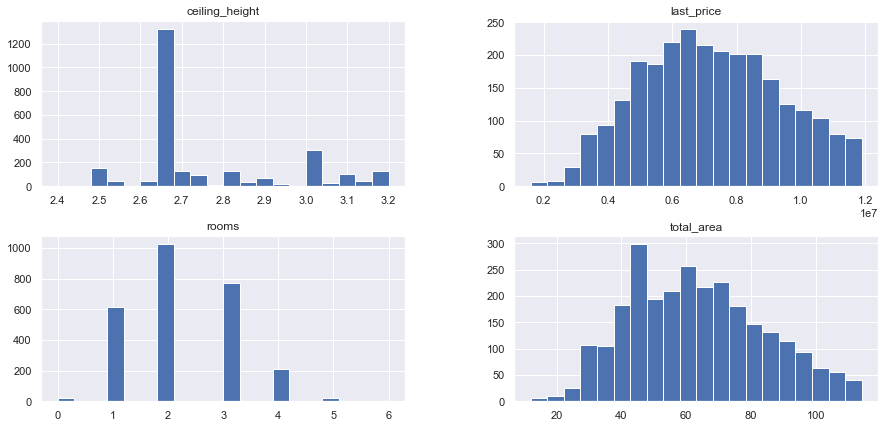

In [46]:
# Рассмотрим следующие параметры квартир в этом сегменте: площадь, цена, число комнат, высота потолков.
spb_downtown[['ceiling_height', 'rooms', 'total_area', 'last_price']].hist(bins=20, figsize=(15,7)); # строим гистрограммы

#### Выводы 
В центре Санкт-Петербурга:
- Подавляющее большинство квартир имеют высоту потолков 2.65 м 
- Средняя типичная цена на квартиры - около 7 млн руб
- Больше всего двухкомнатных квартир
- Большая часть квартир 40 кв м и 60 кв м


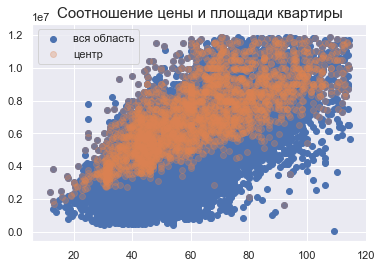

In [47]:
# рассмотрим графики соотношения цены и площади квартиры
plt.scatter(x='total_area', y='last_price', alpha=1, data=clean_data, label='вся область')# график соотношения цены и площади общий 
plt.scatter(x='total_area', y='last_price', data=spb_downtown, alpha=0.3, label='центр')# график соотношения цены и площади в центре
plt.legend(loc='best')
plt.title('Cоотношение цены и площади квартиры', fontsize=15)
plt.show()

#### Вывод
В среднем, в центре чаще встречаются квартиры большей площадью (около 60 кв м против 45-49 по всей области).  
Квартиры в центре находятся в верхнем ценовом сегменте, в отличие от общей статистики там практически невозможно найти недорогие большие квартиры, связь цены и площади более ярко выраженная.  
Таким образом, расположение квартиры в центре - один из важнейших факторов, влияющих на ее цену.

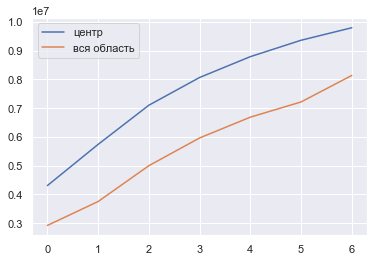

In [48]:
# рассмотрим графики зависимостей цены от количества комнат и цены от количетсва комнат и площади
spb_rooms_price = spb_downtown.pivot_table(index=['rooms'], values='last_price') # сводная таблица комнат/цены по центру Питера
all_rooms_price = clean_data.pivot_table(index=['rooms'], values='last_price') # общая сводная таблица комнат/цены 
plt.plot(spb_rooms_price.index, spb_rooms_price['last_price'], label='центр') # график общий
plt.plot(all_rooms_price.index, all_rooms_price['last_price'], label='вся область') # график по центру
plt.legend(loc='best')
plt.show()

#### Вывод 
В центре квартиры на порядок дороже (типичная цена в среднем около 7 млн руб).  
Кроме того, видим, что, имея общую тенденцию к увеличению цены квартиры с бОльшим количеством комнат, разница цен на 1-2-3-комнатные квартиры в центре менее резкая (спрос в центре высок даже на небольшие квартиры).

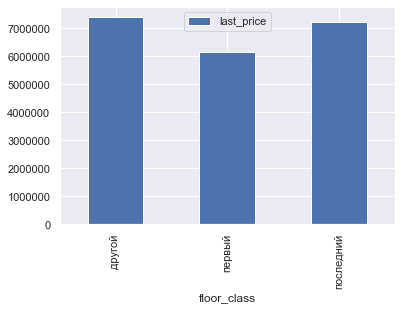

In [49]:
# рассмотрим зависимость цены от этажа квартиры по бар чату по сводной таблице
spb_floor_price = spb_downtown.pivot_table(index='floor_class', values='last_price').plot(kind='bar')

#### Вывод
Как и во всей области, в центре квартиры на первом этаже обычно дешевле.

Коэффициент корреляции цены и отдаленности от центра равен -18%


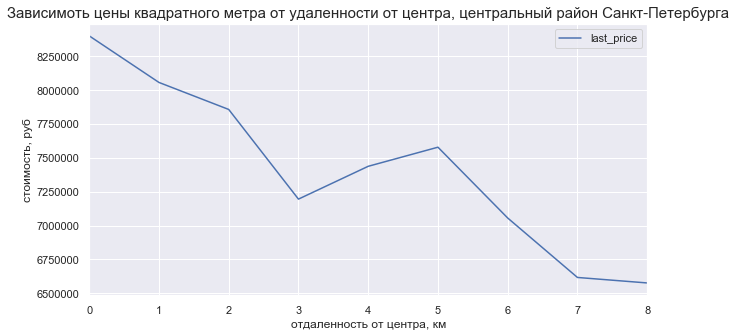

In [50]:
# Отбросим строки с нулевыми значениями в столбце cityCenters_nearest, 
# составим сводную таблицу из этого среза по отдаленности от центра и цене
print('Коэффициент корреляции цены и отдаленности от центра равен {:,.0%}'.format(spb_downtown['km_to_center'].corr(spb_downtown['last_price'])))

spb_downtown.query('cityCenters_nearest != "Nan"').pivot_table(index='km_to_center',
                                                            values='last_price').plot(grid=True, figsize=(10,5))
plt.xlabel('отдаленность от центра, км')
plt.ylabel('стоимость, руб')
plt.title('Зависимоть цены квадратного метра от удаленности от центра, центральный район Санкт-Петербурга', fontsize=15)
plt.show()

#### Вывод 
В целом, чем ближе к самому центру, тем выше стоимость квартиры. Однако коэффициент корреляции здесь ниже, чем по всей области, значит, изменение цен не такое резкое.

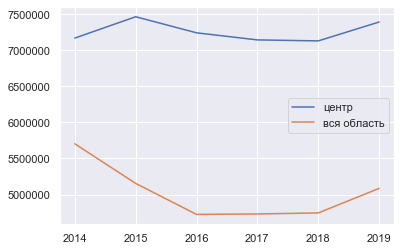

In [51]:
# Посмотрим, как менялась средняя цена на квартиры в период с 2014 по 2019 гг.
spb_year_price = spb_downtown.pivot_table(index='year_of_listing', values='last_price') # сводная таблица по центру 
all_year_price = clean_data.pivot_table(index='year_of_listing', values='last_price') # сводная таблица по всей области
# выводим графики по этим таблицам в одном поле:
plt.plot(spb_year_price.index, spb_year_price['last_price'], label='центр') 
plt.plot(all_year_price.index, all_year_price['last_price'], label='вся область') 
plt.legend(loc='best')
plt.show()

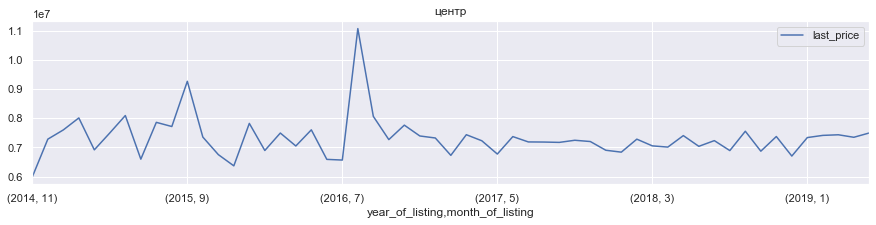

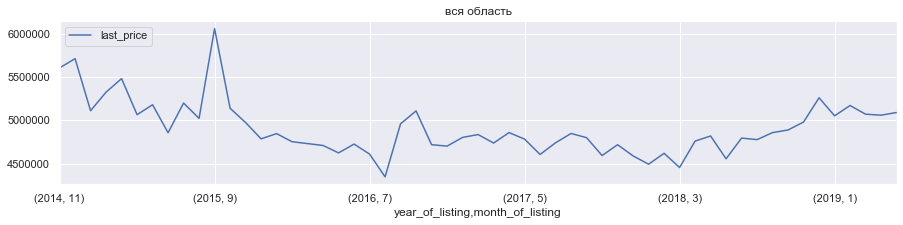

In [52]:
# Рассмотрим динамику цен по времени более детально и сравним с общей тенденцией
# построим сводную таблицу и график зависимости цены от месяца и года выставления квартиры на продажу

spb_y_m_price = spb_downtown.pivot_table(index=['year_of_listing', 'month_of_listing'], values='last_price')
all_y_m_price = clean_data.pivot_table(index=['year_of_listing', 'month_of_listing'], values='last_price')

spb_y_m_price.plot(figsize=(15,3), grid=True, title='центр')
all_y_m_price.plot(figsize=(15,3), grid=True, title='вся область')
plt.legend(loc='upper left')
plt.show()

#### Вывод
В течение времени изменение цен в центре Санкт-Петербурго проходило иначе.  
Как и в общем в области, в сентябре 2015 наблюдался скачок цен, однако когда 2015 везде цены на квартиры понижались, в центре, наоборот, наблюдался рост цен. Пик цен на квартиры в центре приходится как раз на период самых низких цен по области - август 2016 года.  
В дальнейшем до 2018 года также цены снижались, а к 2019 стали подниматься.


## 5. Общий вывод  
<a name='conclusion'></a>
#### [Вернуться к оглавлению](#back) 

**Типичные значения показателей**

В Ленинградской области в среднем:
- Больше всего квартир с площадью около 45-49 кв.м, немного квартир меньше 30 кв.м и более 70 кв.м;
- Больше всего квартир в ценовом диапазоне 3-5 млн руб, квартиры стоимостью меньше 2 млн и больше 7 млн встречаются нечасто;
- Самые часто встречающиеся - однокомнатные и двухкомнатные квартиры, чуть меньше-трехкомнатные. Больше 4 комнат - редкость;
- В основном высота потолков между 2.5 и 2.7 м;
- Средний срок продажи квартиры составляет 180 дней, однако в среднем квартиры продаются за 95 дней. Можно считать, что продажи прошли быстро, если срок составляет менее 45 дней (случаеися в 25% случаев), в редких случаях это занимет более 231 дня. Крайне редко – более 512 дней (5% случаев).

В центре Санкт-Петербурга:
- Подавляющее большинство квартир имеют высоту потолков 2.65 м;
- Средняя типичная цена на квартиры - около 7 млн руб;
- Больше всего двухкомнатных квартир;
- Большая часть квартир 40 кв м и 60 кв м.


**Факторы, влияющие на цену квартир:**  

***- Населенный пунк и близость к административному центру (чем дальше от центра, тем дешевле, но есть исключения)***  
С расстоянием от центра стоимость стремится к понижению, но  в отдельных населенных пунктах недвижимость дорогая, даже не смотря на относительную отдаленность от административного центра. Такими локациями являются Пушкин (101,960.37 руб за кв м) и деревня Кудрово (92,409.73 руб за кв м).

***- Вхождение в центральный район Санкт-Петербурга (прямое, в центре дороже всего)***  
Расположение квартиры в центральной зоне Санкт-Петербурга (до 8 км от центра) - один из важнейших факторов, влияющих на ее цену.  
Квартиры в центре находятся в верхнем ценовом сегменте (типичная цена в среднем около 7 млн руб), в отличие от общей статистики там практически невозможно найти недорогие большие квартиры, связь цены и площади более ярко выраженная. Также в центре чаще встречаются квартиры большей площадью (около 60 кв м против 45-49 по всей области).

***- Общая площадь (влияет прямо, но далеко не всегда)***  
Нередко за одну стоимость можно найти квартиры разной площади.Так, за примерно 2млн руб можно купить квартиру площадью от 20 до 40 кв м. Это означает, что сильно влияние других факторов, таких как населенный пункт и близость к центру.

***- Цена квадратного метра (влияет прямо, но не всегда)***  
В целом, в более дорогих квартирах цена за квадратный метр выше, но в этой тенденции есть исключения, а так же вероятно влияние других факторов.  

***- Количество комнат (влияет, но связанно с увеличением общей площади)***  
На цену влияет количество комнат, но также это связанно и с соответствующим увеличении общей площади (в квартирах побольше обычно больше комнат). Так, мы видим, что квартиры с меньшим количеством комнат, но большей площадью, дороже, чем квартиры поменьше с большим количеством комнат. Таким образом, влияние общей площади квартиры на цену сильнее, чем количество комнат.

***- Этаж (квартиры на первом этаже дешевле)***  
Обычно квартиры на первом этаже немного дешевле, а вот разница в стоимости квартир на последнем этаже и прочих выше первого незначительна. Это актуально и для центра Санкт-Петербурга, и для остальных зон. 

***- Год размещения на продажу (определенно влияет, но определен иными факторами)***  
Зависимость цен от даты размещения вероятнее всего зависит от экономических факторов и событий, таких как кризисы и колебания курсов валют.   
В период с 2014 года цены были максимальны в 2014, затем резко снижались в течение двух лет, достигнув минимума в 2016 году. С 2018 года отмечается значительное повышение цен.  
При этом в сентябре 2015 был резкий скачок цен (средняя цена квартиры в Ленинградской области тогда достигла пика за 5 лет - более 6 млн руб), но за этим последовало быстрое снижение отметки чуть более 4,75 млн руб в течение нескольких месяцев.  
К началу 2019 года цены вышли на уровень середины 2015 года.  

Примечательно, что для ценральной зоны Санкт-Петербурга изменение цен проходило иначе.  
В центре в 2015 наблюдался рост цен. Пик цен на квартиры в центре приходится как раз на период самых низких цен по области - август 2016 года. В остальное вреня тенденции совпадали.  

***- Сезонность (обычно в июне цены ниже, но не всегда)***  
По графику зависимости цен от месяца, можем видеть тенденцию к сезонному снижению цен в июне (исключение составлял 2016 год) и росту к сентябрю.  

***- День недели (статистическая тенденция есть, но неизвестно, чем она обусловлена)***  
В целом, квартиры дороже выставляли на продажу во вторник, дешевле - в субботу. Возможно, такая тенденция является случайной.